# Lane Finder Production Pipeline
## Outputs what we're detecting as the lane 
## Along with live calculations of lane curvature and car distance from center of lane


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def find_lane(image):
    class Left_Line():
        def __init__(self):
        ### to measure values that change per frame
        #TODO initialize and incorporate into functions
    class Right_Line():
        def __init__(self):
        ### ibid

IndentationError: expected an indented block (<ipython-input-1-5413594086d1>, line 10)

## Calibrate the camera lens

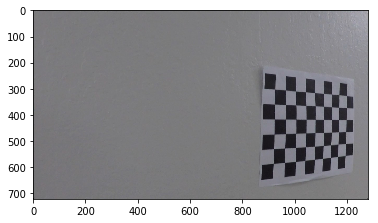

In [117]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt 
%matplotlib inline

# prep and set object and image points
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

# array of images to calibrate
images = glob.glob('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')

test = plt.imread(images[6])
plt.imshow(test)

In [118]:
# loop through images to find and store chessboard corners and comparable blank images
for image in images:
    img = plt.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6))
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

(720, 1280, 3)


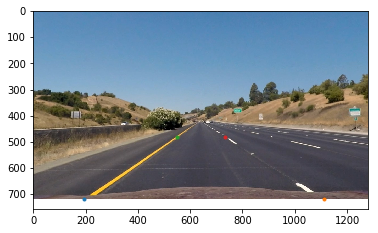

In [119]:
# prep image for testing
img = plt.imread('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg')

# compare where corners are in image to a blank to get calibration matrix and coefficients (weights)
ret, mtx, coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]), None, None)

# use the matrix and weights to undistort the raw image input given to the pipeline
undst = cv2.undistort(img, mtx, coeffs, None, mtx)
cv2.imwrite('/Users/brandoncanniff/Code2020/Self-Driving-Cars/Camera Calibration/CarND-Camera-Calibration/CarND-Advanced-Lane-Lines/output_images/test_undist_road1.jpg', undst)
print(undst.shape)
plt.imshow(undst)

bottom_left = [195, undst.shape[0]]
bottom_right = [1110, undst.shape[0]]
top_left = [550, 480]
top_right = [735, 480]
plt.plot(bottom_left[0], bottom_left[1], '.')
plt.plot(bottom_right[0], bottom_right[1], '.')
plt.plot(top_left[0], top_left[1], '.')
plt.plot(top_right[0], top_right[1], '.')

## Now with an undistorted view of the read we'll change the view to a top down "birds-eye-view"

(720, 1280, 3)


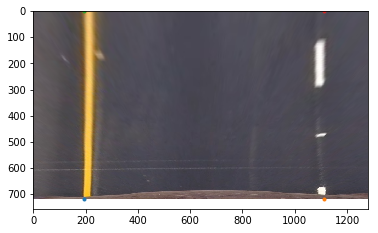

In [120]:
def top_down_warp(undst):
    # 4 corners of the lane
    bottom_left = [195, undst.shape[0]]
    bottom_right = [1110, undst.shape[0]]
    top_left = [550, 480]
    top_right = [735, 480]
    src = np.float32([bottom_left, bottom_right, top_left, top_right])
    # those 4 corners mapped top down
    bottom_left_dst = [195, undst.shape[0]]
    bottom_right_dst = [1110, undst.shape[0]]
    top_left_dst = [195, 0]
    top_right_dst = [1110, 0]
    dst = np.float32([bottom_left_dst, bottom_right_dst, top_left_dst, top_right_dst])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undst, M, (undst.shape[1], undst.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, M
bottom_left_dst = [195, undst.shape[0]]
bottom_right_dst = [1110, undst.shape[0]]
top_left_dst = [195, 0]
top_right_dst = [1110, 0]
top_down, perspective_M = top_down_warp(undst)
print(top_down.shape)
plt.imshow(top_down)
plt.plot(bottom_left_dst[0], bottom_left_dst[1], '.')
plt.plot(bottom_right_dst[0], bottom_right_dst[1], '.')
plt.plot(top_left_dst[0], top_left_dst[1], '.')
plt.plot(top_right_dst[0], top_right_dst[1], '.')

## From this 2-D view we can better see and calculate the curve of the road

### To start we'll set gradient and color thresholds to best detect the lane lines

Text(0.5,1,'X & Y Grad. Filter')

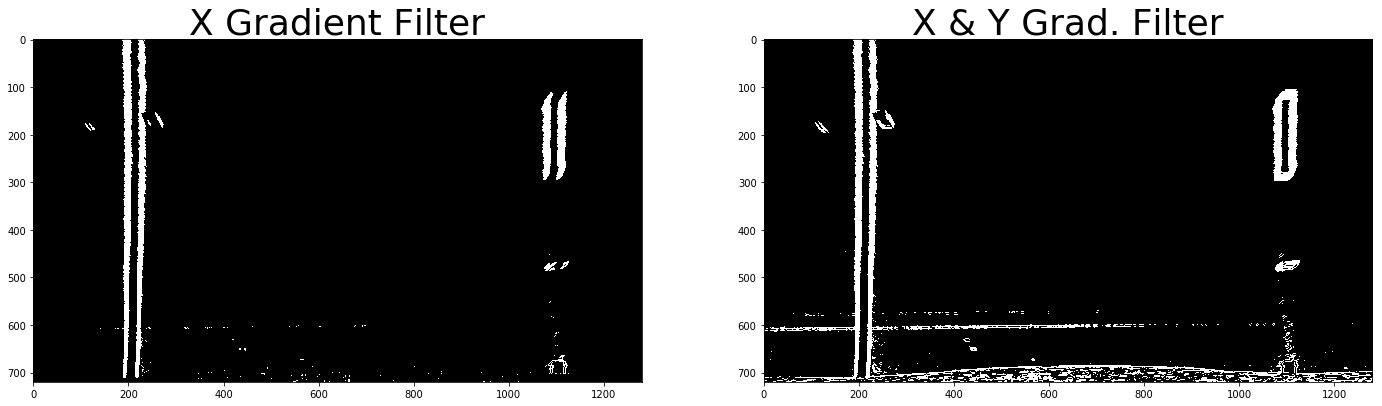

In [131]:
#TODO
# Sobel gradient threshold
# Magnitude threshold
# HSL color threshold
def grad_threshold(img, orient='x', sobel_kernel=3, thresh=(30,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif (orient == 'y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    elif (orient == 'xy'):
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        sobel = np.sqrt(sobelx**2 + sobely**2)
    else:
        return str('orient options: x, y, xy')
    abs_sobel = np.absolute(sobel)
    sbinary = np.zeros_like(abs_sobel)
    sbinary[(abs_sobel > thresh[0]) & (abs_sobel < thresh[1])] = 1
    return sbinary
sobelx_img = grad_threshold(top_down, orient='x')
sobelxy_img = grad_threshold(top_down, orient='xy')
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
ax1.imshow(sobelx_img, cmap='gray')
ax1.set_title('X Gradient Filter', fontsize=36)
ax2.imshow(sobelxy_img, cmap='gray')
ax2.set_title('X & Y Grad. Filter', fontsize=36)

## The X gradient looks pretty good. We can clearly see the lane lines with little noise elsewhere
## Still let's see if we can't do better with HSL color thresholding

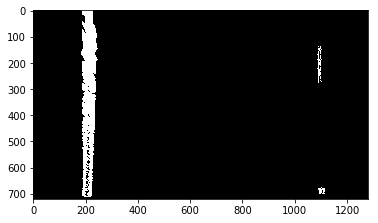

In [129]:
def color_filter(image, thresh=(100,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    h_filter = hls[:,:,0]
    l_filter = hls[:,:,1]
    s_filter = hls[:,:,2]
    sbinary = np.zeros_like(s_filter)
    sbinary[(s_filter > thresh[0]) & (s_filter < thresh[1])] = 1
    return sbinary

s_filter_img = color_filter(top_down)
plt.imshow(s_filter_img, cmap='gray')

## From testing saturation looks to be the most accurate and least noisy across changes in shadows and lane colors
## We'll use the sobel x gradient and saturation levels as our main lane detection thresholds

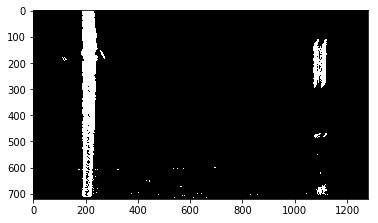

In [134]:
combined_binary = np.zeros_like(s_filter_img)
combined_binary[(sobelx_img == 1) | (s_filter_img == 1)] = 1
plt.imshow(combined_binary, cmap='gray')

## Now we can calculate where the lines are based on where our thresholds are activated (a '1' in our binary image)
## We'll use a sliding window algorithm to find and map the coordinates of those activations

In [ ]:
## left_lane is whichever x value < 600 sums to the highest value
left_lane = np.sum(combined_binary) #TODO can't just take binary bc need to filter specifically by columns